# Train model with MobileNetV3

In [1]:
import torch
from torch.utils.data import DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision import transforms

from vocab import Vocab
from dataset import Paint2CodeDataset
from utils import collate_fn, save_model
from modelArchitecture.modelMobileNetV3 import Encoder, Decoder

In [2]:
def img_transformation(img_crop_size):
    return transforms.Compose([
        transforms.Resize((img_crop_size, img_crop_size)),  # Resize the image
        transforms.ToTensor(),  # Convert the image to tensor
        transforms.Normalize([0.930213], [0.216819]),  # Normalize the image
    ])

## Set parameters

In [3]:
data_path = Path("data", "all_data")
vocab_file_path = Path(data_path.parent, "vocab.txt")
use_cuda = True  
img_size = 224
save_after_epochs = 101
models_dir = Path("./modelsMobileNet/models")
batch_size = 4
epochs = 150
lr = 0.001
seed = 42

# Seed setup for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Set vocabulary

In [4]:
vocab = Vocab(vocab_file_path)
assert len(vocab) > 0, "Vocabulary must be non-empty"

print(vocab)

{
  "START": 0,
  "END": 1,
  "PADDING": 2,
  "UNKNOWN": 3,
  ",": 4,
  "btn-body": 5,
  "btn-header": 6,
  "double": 7,
  "header": 8,
  "image": 9,
  "quadruple": 10,
  "row": 11,
  "single": 12,
  "small-title": 13,
  "text": 14,
  "{": 15,
  "}": 16
}


## Setup GPU for training

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Prepare data

In [6]:
transform_imgs = img_transformation(img_size)

train_loader = DataLoader(
    Paint2CodeDataset(data_path, "train", vocab, transform=transform_imgs),
    batch_size=batch_size,
    collate_fn=lambda data: collate_fn(data, vocab=vocab),
    pin_memory=True if use_cuda else False,
    drop_last=True
)
print("Data loader for train created successfully.")

val_loader = DataLoader(
    Paint2CodeDataset(data_path,"validation", vocab, transform=transform_imgs),
    batch_size=batch_size,
    collate_fn=lambda data: collate_fn(data, vocab=vocab),
    pin_memory=True if use_cuda else False,
    drop_last=True
)
print("Data loader for val  created successfully.")

Data loader for train created successfully.
Data loader for val  created successfully.


## Set model parameters

In [7]:
embed_size = 64
hidden_size = 256
num_layers = 2

# Initialize the Encoder and Decoder
encoder = Encoder(embed_size).to(device)
decoder = Decoder(embed_size, hidden_size, len(vocab), num_layers).to(device)

print("Models are initialized and moved to the designated device.")

Models are initialized and moved to the designated device.


## Define loss function and optimizer

In [8]:
criterion = torch.nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

print("Loss function and optimizer are set.")

Loss function and optimizer are set.


## Train loop

In [9]:
# Initialize lists to store the average losses per epoch
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(epochs):
    # Training phase
    encoder.train()  # Set the encoder to training mode
    decoder.train()  # Set the decoder to training mode
    total_train_loss = 0
    num_batches = 0

    for images, captions, lengths in train_loader:
        images = images.to(device)
        captions = captions.to(device)
        targets = torch.nn.utils.rnn.pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Zero the gradients
        encoder.zero_grad()
        decoder.zero_grad()

        # Forward pass
        features = encoder(images)
        output = decoder(features, captions, lengths)

        # Calculate loss
        loss = criterion(output, targets)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        num_batches += 1

    avg_train_loss = total_train_loss / num_batches
    train_losses.append(avg_train_loss)  # Append the average training loss

    # val phase
    encoder.eval()  # Set the encoder to evaluation mode
    decoder.eval()  # Set the decoder to evaluation mode
    total_val_loss = 0
    num_val_batches = 0

    with torch.no_grad():  # No need to track gradients during val
        for images, captions, lengths in val_loader:
            images = images.to(device)
            captions = captions.to(device)
            targets = torch.nn.utils.rnn.pack_padded_sequence(captions, lengths, batch_first=True)[0]

            # Forward pass
            features = encoder(images)
            output = decoder(features, captions, lengths)

            # Calculate loss
            loss = criterion(output, targets)
            total_val_loss += loss.item()
            num_val_batches += 1

    avg_val_loss = total_val_loss / num_val_batches
    val_losses.append(avg_val_loss)  # Append the average val loss

    # Print integrated loss statistics in one line
    print(f'Epoch {epoch}: Training Loss {avg_train_loss:.4f}, val Loss {avg_val_loss:.4f}')

    #Save model checkpoint
    if epoch != 0 and epoch % save_after_epochs == 0:
        save_model(models_dir, encoder, decoder, optimizer, epoch, avg_val_loss, batch_size, vocab)
        print("Saved model checkpoint at epoch:", epoch)

print("Training completed!")

Starting training...
Epoch 0: Training Loss 0.3759, val Loss 0.1214
Epoch 1: Training Loss 0.1166, val Loss 0.1065
Epoch 2: Training Loss 0.1058, val Loss 0.0995
Epoch 3: Training Loss 0.0995, val Loss 0.0974
Epoch 4: Training Loss 0.0989, val Loss 0.1008
Epoch 5: Training Loss 0.0965, val Loss 0.0876
Epoch 6: Training Loss 0.0903, val Loss 0.0850
Epoch 7: Training Loss 0.0890, val Loss 0.0968
Epoch 8: Training Loss 0.0909, val Loss 0.0932
Epoch 9: Training Loss 0.0904, val Loss 0.0809
Epoch 10: Training Loss 0.0870, val Loss 0.0804
Epoch 11: Training Loss 0.0842, val Loss 0.0780
Epoch 12: Training Loss 0.0826, val Loss 0.0777
Epoch 13: Training Loss 0.0832, val Loss 0.0818
Epoch 14: Training Loss 0.0814, val Loss 0.0791
Epoch 15: Training Loss 0.0806, val Loss 0.0803
Epoch 16: Training Loss 0.0821, val Loss 0.0728
Epoch 17: Training Loss 0.0778, val Loss 0.0707
Epoch 18: Training Loss 0.0758, val Loss 0.0700
Epoch 19: Training Loss 0.0752, val Loss 0.0711
Epoch 20: Training Loss 0.074

## Plot the training and val losses

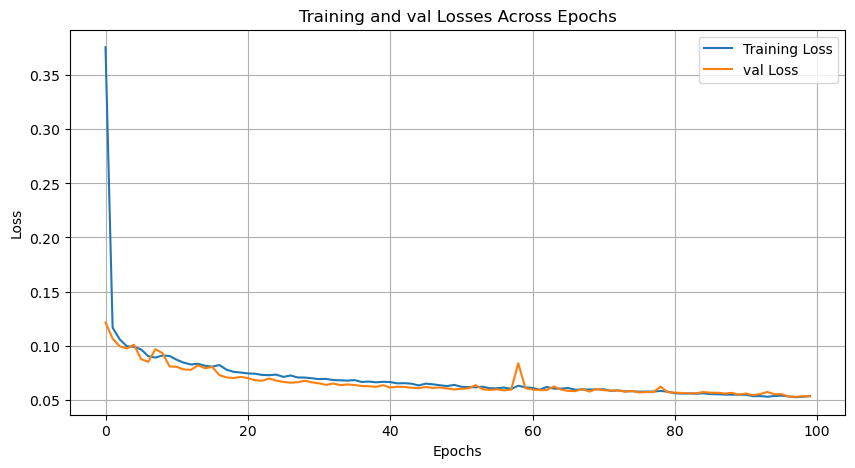

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='val Loss')
plt.title('Training and val Losses Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()